# アダブースト
- アダブーストと決定木を使って多クラス分類問題を解いてみよう
- ハイパーパラメータを変更して、結果の変化を確認しよう
- graphvizを使って各決定木の中身を可視化してみよう

## 1. ライブラリの読み込み

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# データセット
from sklearn.datasets import load_iris
# データの分割
from sklearn.model_selection import train_test_split 
# 多クラス分類の評価指標
from sklearn.metrics import accuracy_score, classification_report

# モデルの可視化
from io import StringIO
from sklearn.tree import export_graphviz
import graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image

# 決定木＋アダブーストによる分類モデル
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

## 2. データの読み込み
- [The Iris Dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)
  - アヤメの品種分類のデータセット
  - 目的変数（クラス）
      - Setosa
      - Versicolor
      - Virginica
  - 説明変数
      - Sepal Length（萼片の長さ）
      - Sepal Width（萼片の幅）
      - Petal Length（花弁の長さ）
      - Petal Width（花弁の幅）

In [2]:
# データセットの読み込み
iris = load_iris()

# 説明変数をデータフレームに変換
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
# 目的変数をデータフレームに追加
df_iris["label"] = iris.target

# クラス番号を文字列に置き換え
df_iris["label"] = df_iris["label"].map(
    {0:iris.target_names[0], 
     1:iris.target_names[1], 
     2:iris.target_names[2]}
)

df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## 3. データの可視化

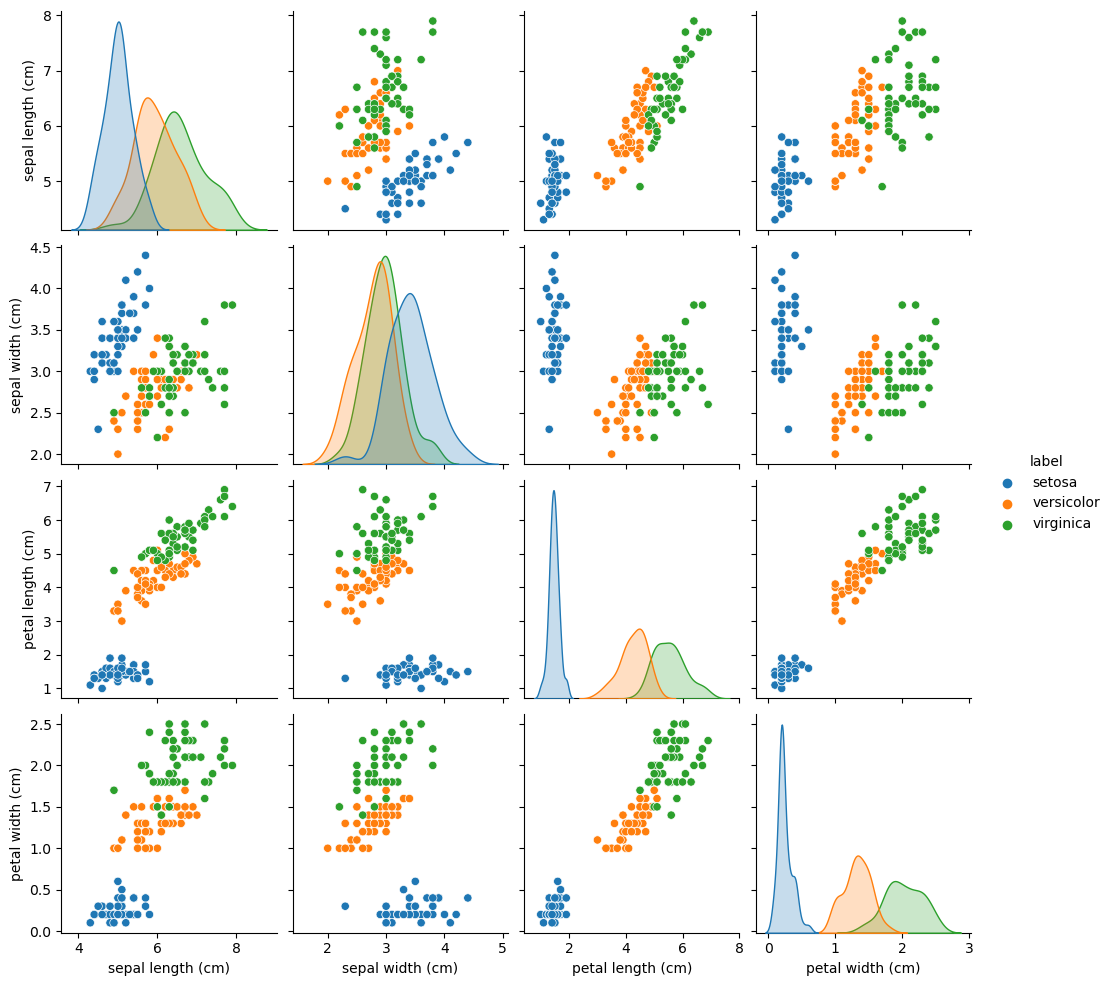

In [3]:
# 散布図行列の表示（クラスごとに色分け）
sns.pairplot(df_iris, hue="label")
plt.show()

## 4. モデルの構築・学習

In [4]:
# 学習用・テスト用の分割
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.4, random_state=1234
)

# アダブーストの構築
# 最初の引数で弱学習器を設定
# それ以外の引数はランダムフォレストと同様
clf = AdaBoostClassifier(
    DecisionTreeClassifier(
        max_depth=3,
        min_samples_leaf=2,
        min_samples_split=2, 
        random_state=1234,
        criterion="gini"
    ),
    n_estimators=10, 
    random_state=1234
)

# モデルの学習
clf.fit(X_train, y_train)

# 訓練性能の確認
print("train_accuracy: ", clf.score(X_train, y_train))

train_accuracy:  1.0


### [演習]
* 不純度の評価方法を変更してみましょう
* max_depthの値を変更してみましょう
* min_samples_splitの値を変更してみましょう
* min_samples_leafの値を変更してみましょう
* n_estimaroesの値を変更してみましょう

## 5. モデルの評価

In [5]:
# 汎化性能の確認
print("test_accuracy:", clf.score(X_test, y_test))

# 予測結果の取得
y_pred = clf.predict(X_test)

# 評価指標の確認
scores = classification_report(y_test, y_pred)
print(scores)

test_accuracy: 0.9833333333333333
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.96      0.98        23
           2       0.95      1.00      0.97        18

    accuracy                           0.98        60
   macro avg       0.98      0.99      0.98        60
weighted avg       0.98      0.98      0.98        60



## 6. 変数の重要度を確認

[0.17003038 0.31232333 0.26811629 0.24952999]


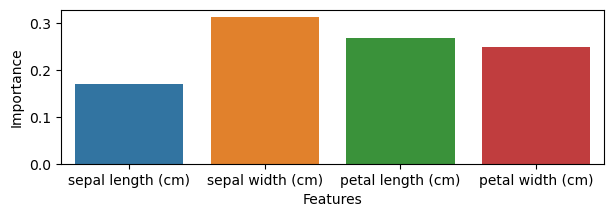

In [6]:
# 説明変数の重要度を出力する
# 重要度＝ある説明変数による不純度の減少量の合計
print(clf.feature_importances_)

# データフレームの作成
feature_imp = pd.DataFrame(
    clf.feature_importances_, 
    index=iris.feature_names, columns=['Importance']
)

# 棒グラフの表示
plt.figure(figsize=(7,2))
sns.barplot(x=feature_imp.index, y=feature_imp['Importance'])
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

## 7. モデルの可視化

Tree 0


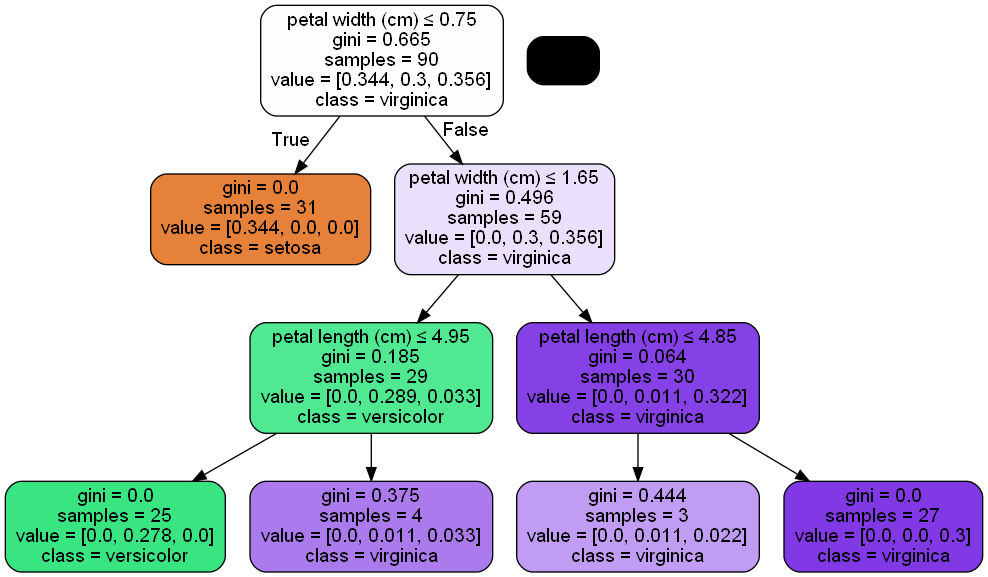

Tree 1


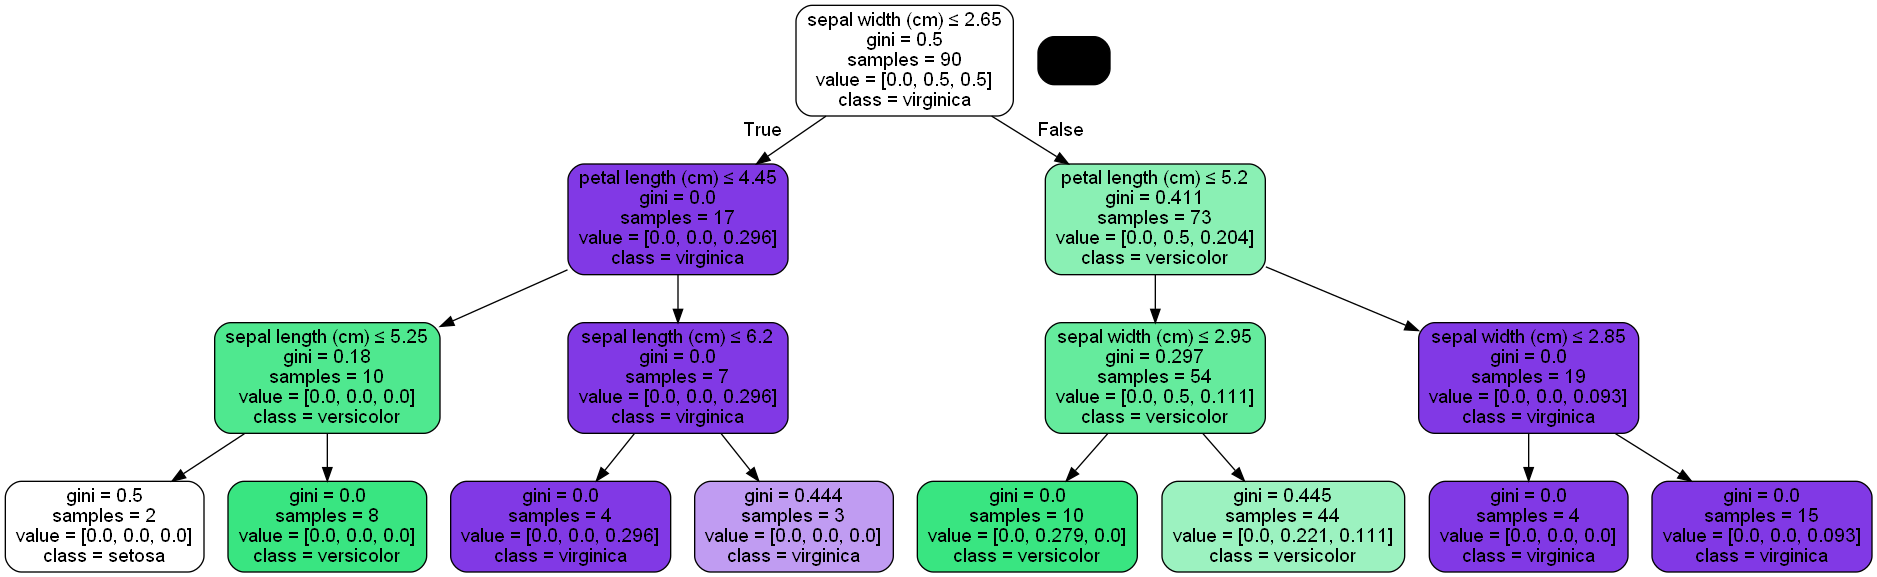

Tree 2


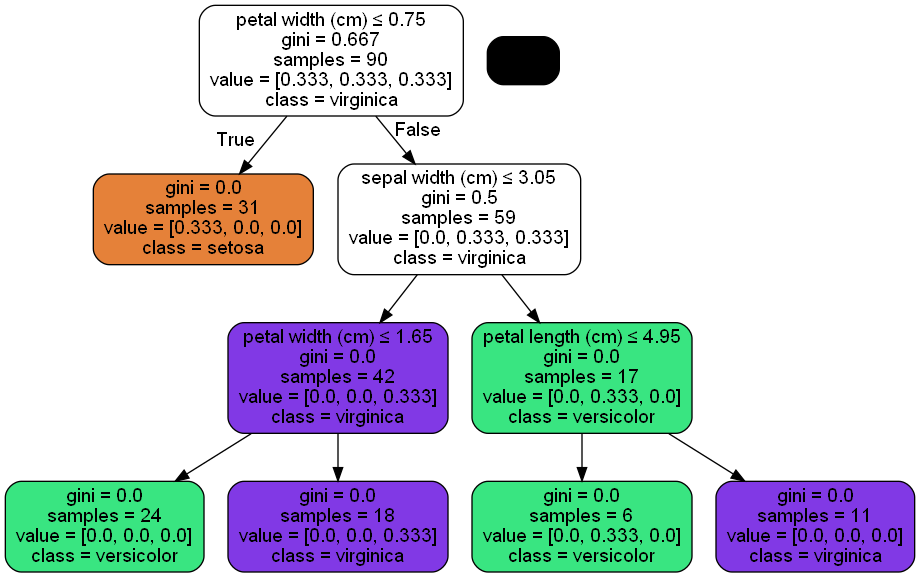

Tree 3


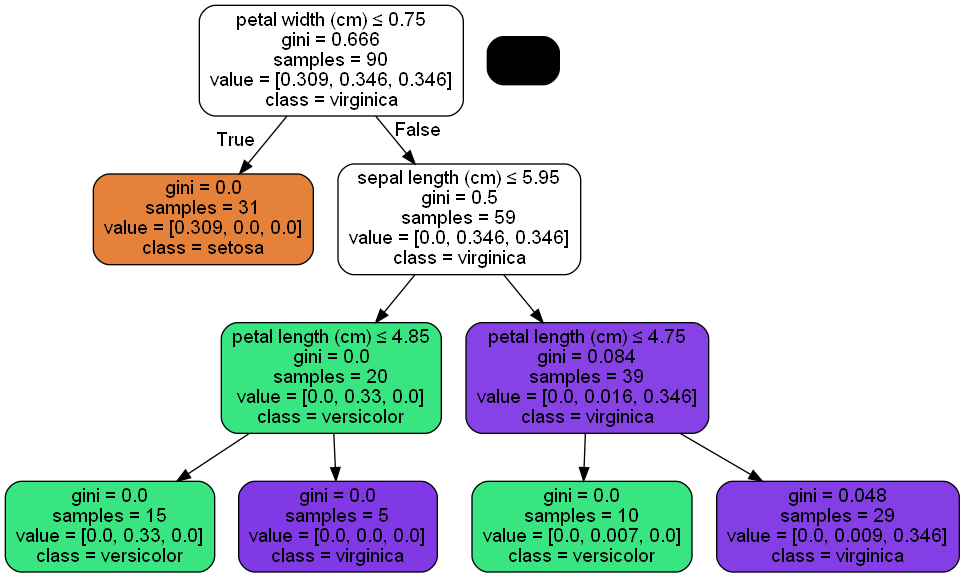

Tree 4


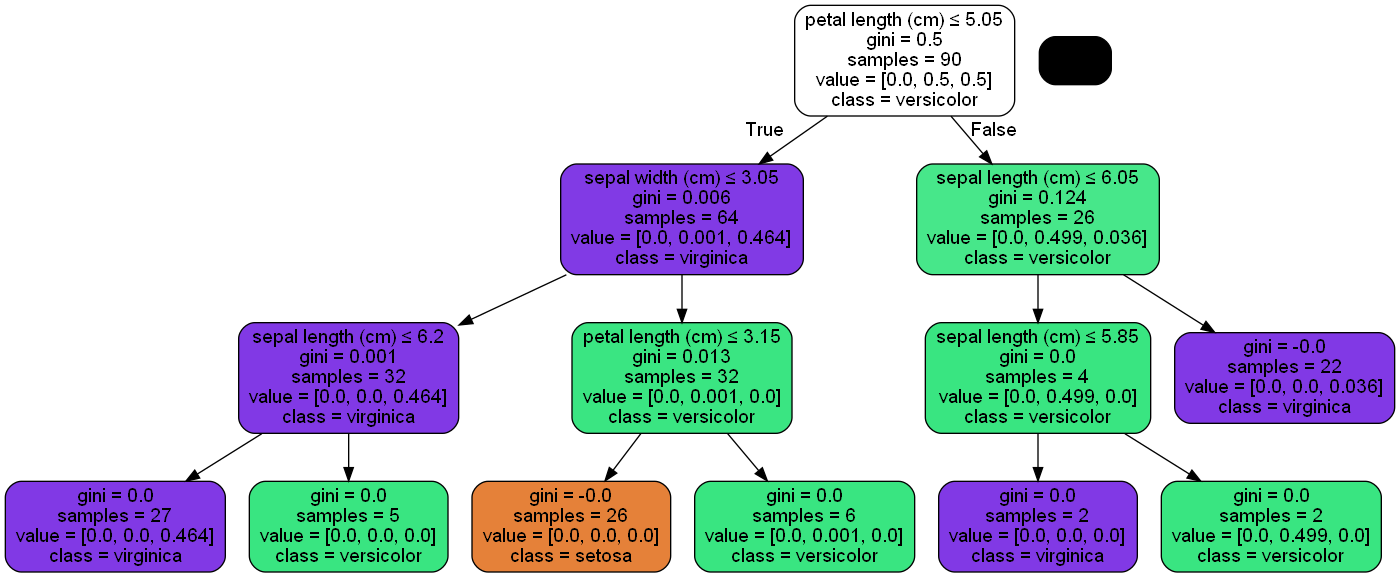

Tree 5


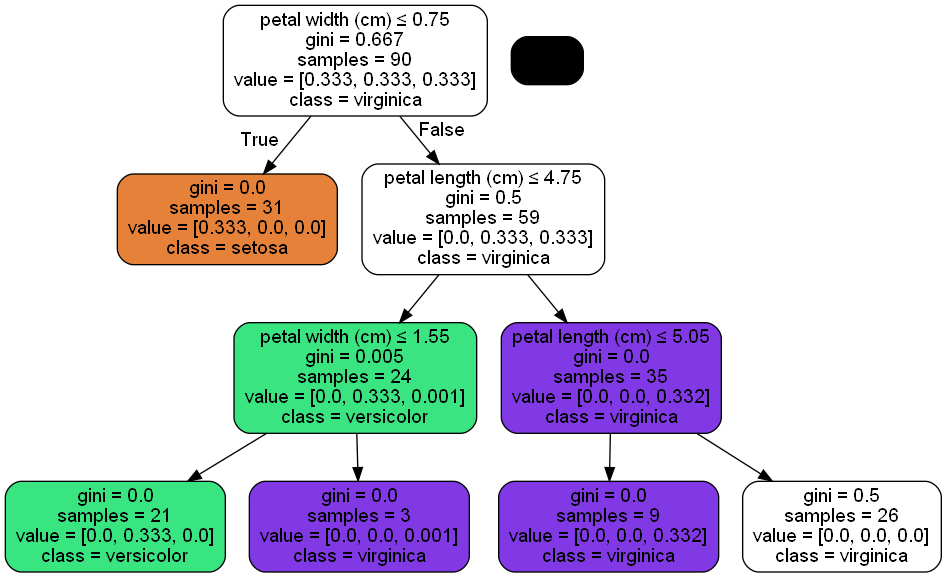

Tree 6


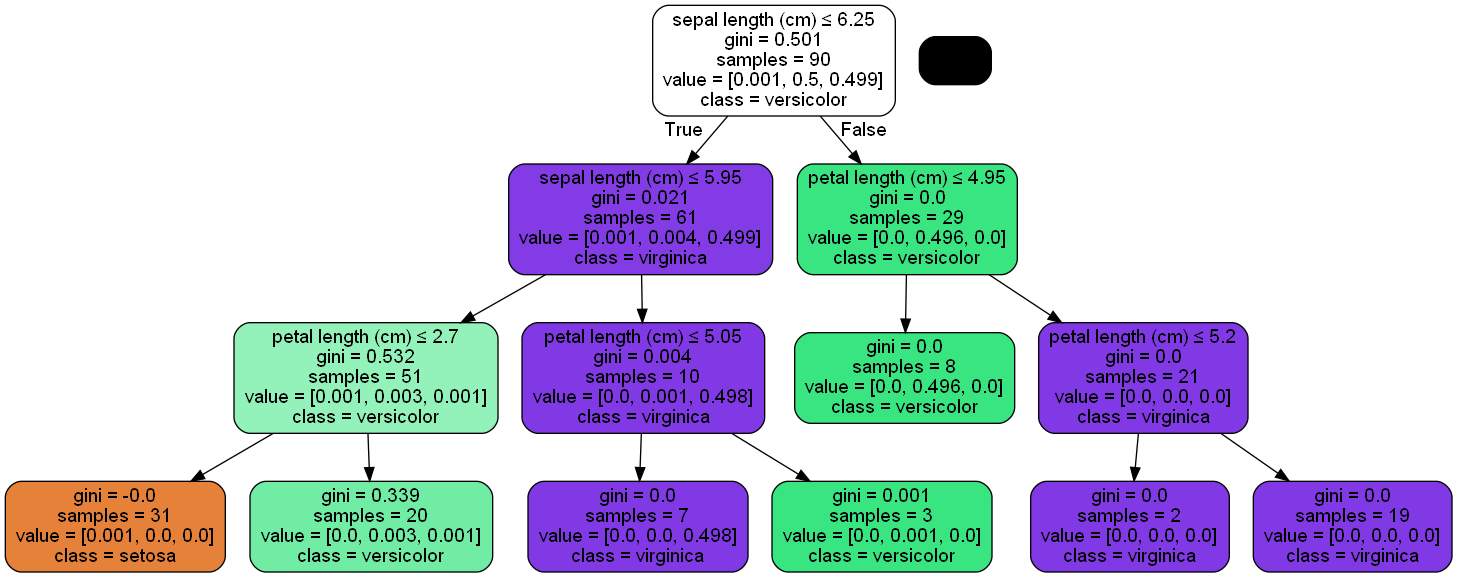

Tree 7


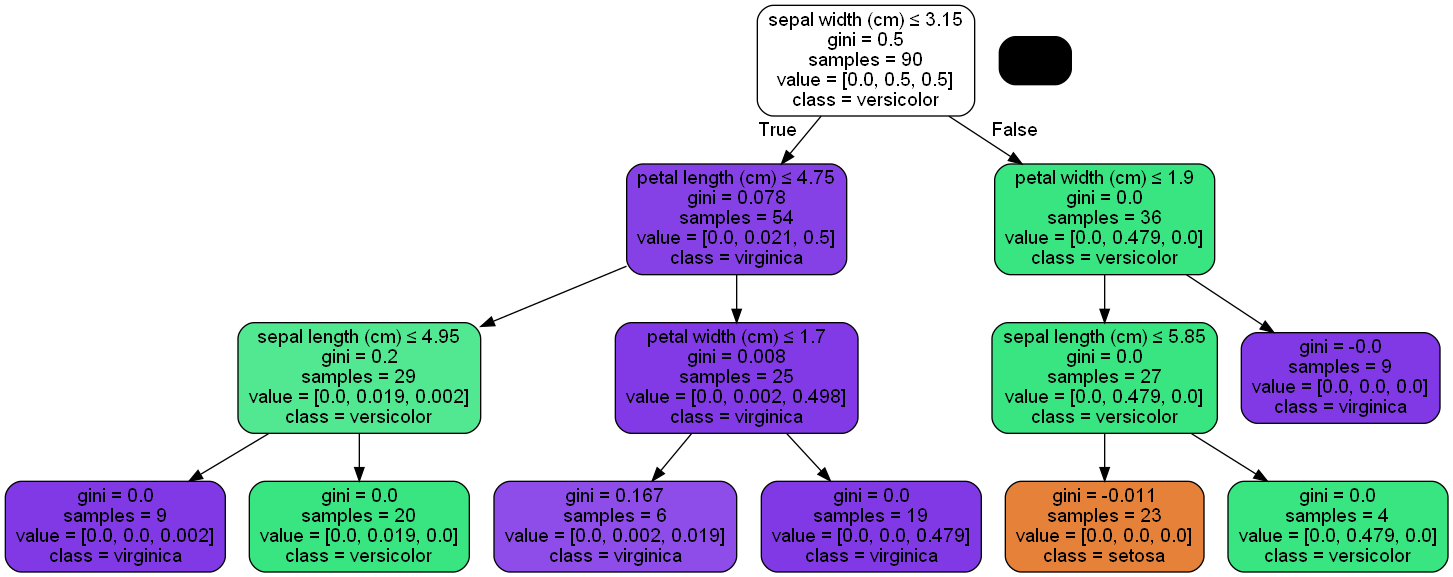

Tree 8


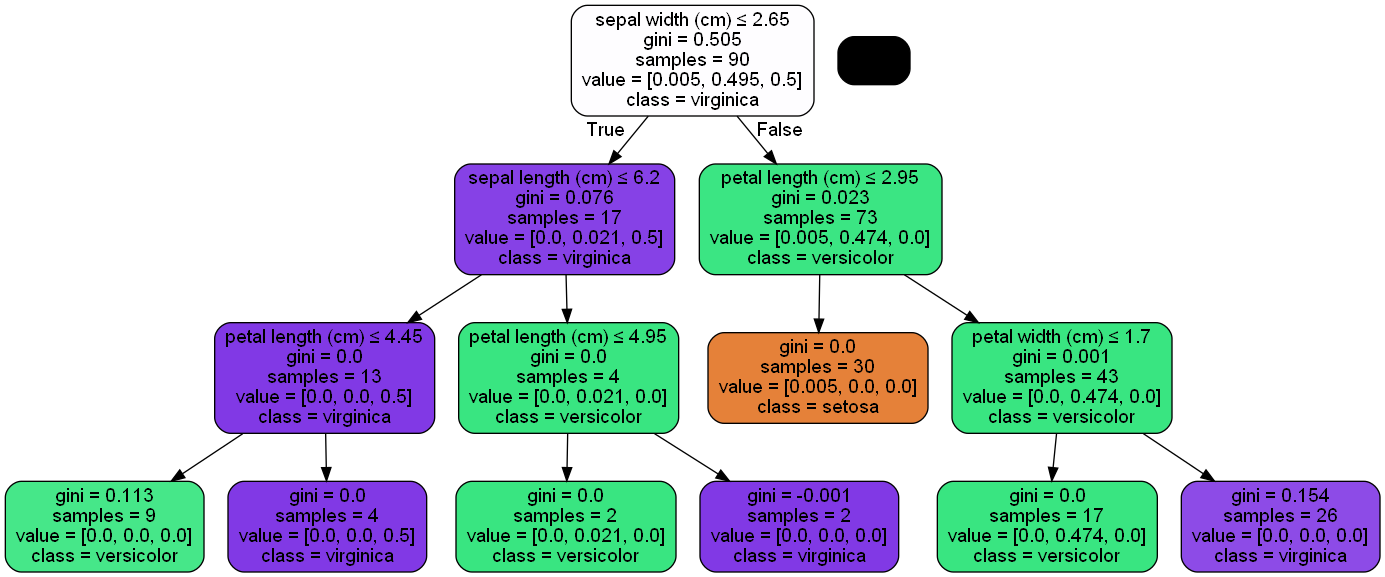

Tree 9


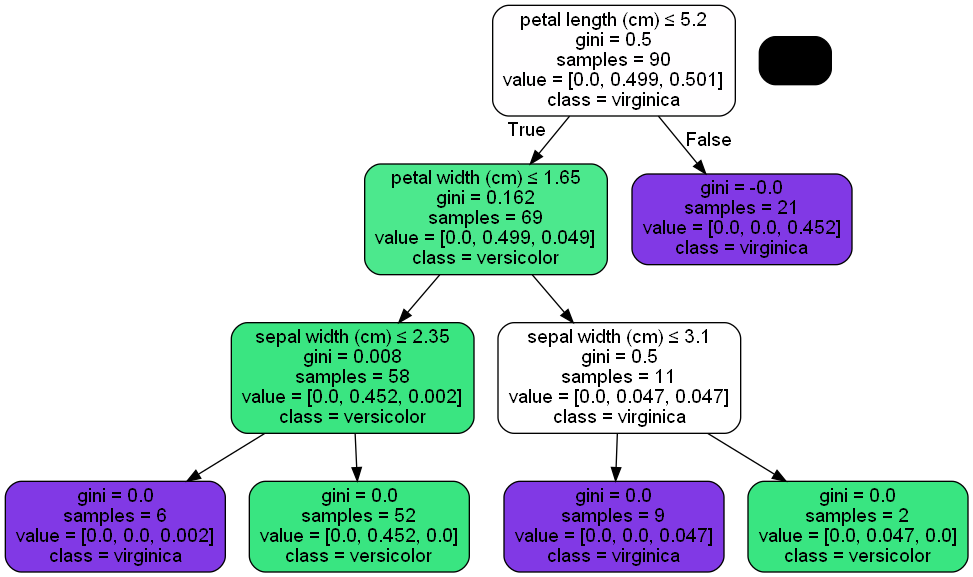

In [7]:
# アダブーストのモデルから決定木を取り出す
for i, est in enumerate(clf.estimators_):
    print("Tree", i)
    
    # DOTファイルの格納先（文字列として保持）
    dot_data = StringIO()
    
    # モデルをDOTファイルとして出力
    export_graphviz(
        est, out_file=dot_data,  
        feature_names=iris.feature_names,  
        class_names=iris.target_names,  
        filled=True, rounded=True,  
        special_characters=True
    ) 
    
    # DOTファイルを読み込む
    graph = graph_from_dot_data(dot_data.getvalue()) 
    
    # PNG形式の画像として表示
    display(Image(graph.create_png()))